In [1]:
import sympy as sp
import minterpy as mp
import numpy as np
from minterpy.pointcloud_utils import *

from mpl_toolkits import mplot3d
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

import torch
import torchvision
from torchvision import transforms, datasets

import random
import numpy as np
import matplotlib.pyplot as plt

import os
from operator import itemgetter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import ot

from sklearn.neighbors import NearestNeighbors

import ripser
import persim
from persim import plot_diagrams

from operator import itemgetter


#do pip installs as follows to use vedo for plotting point clouds
#pip install vedo
#pip install ipyvtklink

import numpy as np
from vedo import *

import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def give_centeroid(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    sum_z = np.sum(arr[:, 2])
    return np.array([[sum_x/length, sum_y/length, sum_z/length]])

In [3]:
def give_next_neighbours_barycenter_indices(batch_x, input_barycenter, remaining_indices, num_neighbours):
  wasserDistance = []
  distance_cum_index = np.array([])

  for j in remaining_indices:
    
    wassDistance = dist = np.linalg.norm(batch_x[j]-input_barycenter)

    
    distance_cum_index = np.concatenate((distance_cum_index, np.array([wassDistance, j])), axis = 0)
   
  distance_cum_index = distance_cum_index.reshape(int(distance_cum_index.shape[0]/2), 2)
  distance_cum_index = sorted(distance_cum_index, key=itemgetter(0))
  
  distance_cum_index = np.array(distance_cum_index)
  
  remaining_indices = distance_cum_index[:,1]

  remaining_indices = remaining_indices.astype(int)
  
    
  A = np.array([])
  for i in range(num_neighbours):
    if(i >= distance_cum_index[:,1].shape[0]):
        break
    A = np.concatenate((A, batch_x[int(distance_cum_index[:,1][i])]), axis = 0 )
  
  A = A.reshape(int(A.shape[0]/3) , 3)

  next_barycenter = give_centeroid(A) 
  
  next_barycenter = np.array(next_barycenter)
  #print(next_barycenter.shape)
  next_barycenter = next_barycenter.reshape(next_barycenter.shape[0]* next_barycenter.shape[1])
  #print(next_barycenter.shape)  
  return A, next_barycenter, remaining_indices


In [4]:
def get_convergent_barycenters(point_cloud, no_neighbours, initial_pt):    
    bary = initial_pt
    rem_indices = np.array(range(0,point_cloud.shape[0]))
    #print("Size of batch : ", point_cloud.shape[0])
    sampled_barycenters = np.array([])
    sampled_barycenters = torch.tensor(sampled_barycenters)
    covered_indices = np.array([])

    for i in range(int(point_cloud.shape[0])):

        if(len(rem_indices) < 2):
            #print("END")
            break

        #print("Iteration number : ", i+1)
        #print("Input barycenter : ")


        old_bary = bary



        neighbours, bary, rem_indices = give_next_neighbours_barycenter_indices(point_cloud, bary, rem_indices, no_neighbours)



        wassDistance = np.linalg.norm(old_bary - bary)  

        covered_indices = np.concatenate((covered_indices, rem_indices[:no_neighbours] ) ,axis = 0)


        #print("Tracking distance between new barycenter and previous barycenter : ",wassDistance )
        if(wassDistance == 0.0):

            unique_covered_indices = np.unique(covered_indices, axis=0)
            sampled_barycenters = torch.cat((sampled_barycenters, torch.tensor(bary)), 0)

            s1 = set(rem_indices)
            s2 = set(unique_covered_indices)
            rem_set = s1 - s2
            rem_inds = list(rem_set)
            rem_indices = rem_set
            #print("Sampled barycenters are")
            #print(sampled_barycenters)
    sampled_barycenters = sampled_barycenters.reshape(int((sampled_barycenters.shape[0]/3)),3)
    
    return sampled_barycenters

In [5]:
def _compute_distance_matrix(x, p=2):
    x_flat = x.view(x.size(0), -1)

    distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)

    return distances

In [6]:
def get_persistence_diagram(point_cloud, maximum_dim):

    point_cloud = torch.tensor(point_cloud)

    dist_matrix = _compute_distance_matrix(point_cloud, p=2)
    diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=maximum_dim)['dgms']
    return diagrams, plot_diagrams(diagrams, show=True)


# Torus in 3D

In [7]:
x, y, z = sp.symbols('x y z')


In [8]:
## Torus
R = 1.5
r = 0.7
expr_torus = (x**2 + y**2 + z**2 + R**2 - r**2)**2 - 4*R**2*(x**2 + y**2)


In [9]:
expr_torus

-9.0*x**2 - 9.0*y**2 + 3.0976*(0.568181818181818*x**2 + 0.568181818181818*y**2 + 0.568181818181818*z**2 + 1)**2

In [10]:
poly_torus = sp.Poly(expr_torus, x, y, z)

In [11]:
sp.expand(expr_torus)

1.0*x**4 + 2.0*x**2*y**2 + 2.0*x**2*z**2 - 5.48*x**2 + 1.0*y**4 + 2.0*y**2*z**2 - 5.48*y**2 + 1.0*z**4 + 3.52*z**2 + 3.0976

In [12]:
#Convert sympy polynomial to minterpy polynomial

newt_poly_torus = sympy_to_mp(poly_torus, mp.NewtonPolynomial)

In [13]:
#Sample points on the zero isocontour

point_data_torus = sample_points_on_poly(1000,        # Number of points to be sampled
                                   newt_poly_torus,  # Polynomial in Newton basis
                                   bounds=3.0, # Boundary of the Cubic domain to be sampled
                                   tol=1e-15)  # Tolerance in solution

In [14]:
point_data_torus.shape

(1000, 3)

In [36]:
x_t = point_data_torus[:,0]
y_t = point_data_torus[:,1]
z_t = point_data_torus[:,2]


plot_points = [x_t,y_t,z_t]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# demo of barycenter convergence on a torus


In [16]:
nachbarn = 20

In [17]:
#demo of barycenter convergence on a torus

bary = point_data_torus[0]
rem_indices = np.array(range(0,point_data_torus.shape[0]))
print("Size of batch : ", point_data_torus.shape[0])
sampled_barycenters = np.array([])
sampled_barycenters = torch.tensor(sampled_barycenters)
covered_indices = np.array([])

for i in range(int(point_data_torus.shape[0])):
        
    if(len(rem_indices) < 2):
        print("END")
        break
    
    print("Iteration number : ", i+1)
    print("Input barycenter : ")
    print(bary)

    old_bary = bary
    

    
    neighbours, bary, rem_indices = give_next_neighbours_barycenter_indices(point_data_torus, bary, rem_indices, nachbarn)
        
    print("neighbours found : ")
    print(neighbours)

    
    wassDistance = np.linalg.norm(old_bary - bary)  
    
    covered_indices = np.concatenate((covered_indices, rem_indices[:nachbarn] ) ,axis = 0)


    print("Tracking distance between new barycenter and previous barycenter : ",wassDistance )
    if(wassDistance == 0.0):

        unique_covered_indices = np.unique(covered_indices, axis=0)
        sampled_barycenters = torch.cat((sampled_barycenters, torch.tensor(bary)), 0)

        s1 = set(rem_indices)
        s2 = set(unique_covered_indices)
        rem_set = s1 - s2
        rem_inds = list(rem_set)
        rem_indices = rem_set
        print("Sampled barycenters are")
        print(sampled_barycenters.reshape(int((sampled_barycenters.shape[0]/3)),3))
sampled_barycenters = sampled_barycenters.reshape(int((sampled_barycenters.shape[0]/3)),3)


Size of batch :  1000
Iteration number :  1
Input barycenter : 
[-1.24229018  1.81332902  0.05214224]
neighbours found : 
[[-1.24229018  1.81332902  0.05214224]
 [-1.18275127  1.84372558  0.11502368]
 [-1.27643303  1.79080531 -0.03446642]
 [-1.16468639  1.86617483 -0.01689437]
 [-1.20663979  1.80051657  0.21097511]
 [-1.1544123   1.86660829 -0.08563278]
 [-1.0941236   1.90000538  0.10208544]
 [-1.41172164  1.68711998 -0.0145803 ]
 [-1.47229576  1.63036791 -0.06727226]
 [-1.50677387  1.59654165  0.08103829]
 [-0.9571832   1.97099418 -0.11112923]
 [-1.37404028  1.61005411  0.33125086]
 [-1.21783654  1.67242896  0.40793203]
 [-1.19090581  1.68806467  0.41205717]
 [-1.52658056  1.57992668 -0.06520789]
 [-0.82469872  2.0200624   0.15806166]
 [-1.4595077   1.55149844 -0.30492408]
 [-1.49158046  1.49199473  0.34388699]
 [-1.30367123  1.60507133 -0.40938835]
 [-1.10254261  1.72508104 -0.43639965]]
Tracking distance between new barycenter and previous barycenter :  0.08156320020384106
Iteration

neighbours found : 
[[-1.04234244  0.42087164  0.59051037]
 [-1.04791607  0.45345383  0.60141973]
 [-0.97990816  0.33344917  0.52331383]
 [-1.01215662  0.27373537  0.53494383]
 [-0.87610922  0.38709105  0.44275713]
 [-1.10602937  0.31990057  0.60700282]
 [-0.97510559  0.23854383  0.49380633]
 [-1.15766614  0.34839528  0.63662573]
 [-1.1493499   0.49459458  0.65431179]
 [-1.0924271   0.24232992  0.58721827]
 [-1.00500001  0.18688865  0.51160042]
 [-0.94791961  0.6885454   0.61818556]
 [-0.82445829  0.31672539  0.33099954]
 [-0.75970482  0.56003339  0.42504053]
 [-0.93096646  0.1549102   0.424976  ]
 [-0.76687787  0.39925764  0.2936811 ]
 [-1.06465996  0.04711727  0.5489857 ]
 [-1.29361904  0.21659732  0.67417765]
 [-0.79318837  0.2605932   0.21826788]
 [-0.94713546  0.82121683  0.65519246]]
Tracking distance between new barycenter and previous barycenter :  0.06616747027091793
Iteration number :  20
Input barycenter : 
[-0.98862702  0.35821253  0.51865083]
neighbours found : 
[[-0.97990

Sampled barycenters are
tensor([[-1.3735,  1.6609,  0.0809],
        [-1.5767,  1.1693,  0.4597],
        [-1.0124,  0.3352,  0.5209],
        [-1.0474, -0.4062,  0.5445],
        [-1.1944, -1.2867,  0.6285],
        [-1.1047, -1.7862,  0.2094]], dtype=torch.float64)
Iteration number :  44
Input barycenter : 
[-1.10474082 -1.78615482  0.20938369]
neighbours found : 
[[-1.10189498 -1.81234811 -0.32298424]
 [-0.98074051 -1.87489017 -0.33265265]
 [-1.01370791 -1.80356767 -0.40782565]
 [-0.5891591  -1.77426602  0.59451691]
 [-0.85816259 -1.90403776 -0.37904623]
 [-0.74946562 -2.00032931 -0.29214575]
 [-0.5865709  -1.73563894  0.61621793]
 [-0.88315285 -1.8541987  -0.42816802]
 [-1.08123133 -1.70375204 -0.47095884]
 [-0.47486382 -1.98932457  0.43902127]
 [-0.51323531 -1.78531764  0.60175125]
 [-1.62497625 -1.45802205 -0.15242513]
 [-0.87361857 -1.81678437 -0.47310814]
 [-0.43775655 -2.09191419  0.28972882]
 [-0.7387297  -1.92061086 -0.42294089]
 [-0.6758879  -1.96909656 -0.3891427 ]
 [-1.18

neighbours found : 
[[-1.33774711  0.46748847 -0.69507129]
 [-1.57024633  0.28867182 -0.69330808]
 [-1.61846511  0.43894493 -0.67727023]
 [-1.52409705  0.20784406 -0.6989567 ]
 [-1.65292809  0.38490992 -0.67166275]
 [-1.30955848  0.59711096 -0.69736024]
 [-1.74000112  0.34997744 -0.64378425]
 [-1.6896306   0.2101466  -0.67002495]
 [-1.1551024   0.37264603 -0.63878495]
 [-1.61672371  0.63388715 -0.65881996]
 [-1.10752814  0.4139422  -0.62378086]
 [-1.72443812  0.1607378  -0.66046669]
 [-1.69444015  0.09180628 -0.6717294 ]
 [-1.65976183  0.05729279 -0.68129239]
 [-1.10271196  0.56148042 -0.6488892 ]
 [-1.06288287  0.45376857 -0.60946909]
 [-1.8352296   0.27219386 -0.60312375]
 [-1.60588956  0.76863369 -0.64140369]
 [-1.02264998  0.41046304 -0.57580888]
 [-1.47006322  0.82743892 -0.67457858]]
Tracking distance between new barycenter and previous barycenter :  0.03177342838135812
Iteration number :  72
Input barycenter : 
[-1.47500477  0.39846925 -0.6567793 ]
neighbours found : 
[[-1.57024

neighbours found : 
[[ 0.90219948  1.63934673 -0.59346793]
 [ 0.9031172   1.79029714 -0.48454481]
 [ 0.96700429  1.62076847 -0.58307887]
 [ 0.98516817  1.76226194 -0.46978725]
 [ 1.06587407  1.64633849 -0.5265402 ]
 [ 1.09330023  1.69733628 -0.46975103]
 [ 0.88746846  1.89763865 -0.36889892]
 [ 0.75970134  1.92867786 -0.40221548]
 [ 0.86696071  1.43427918 -0.67752847]
 [ 1.15380587  1.67558996 -0.45209951]
 [ 1.0106769   1.87512099 -0.30480938]
 [ 0.96714135  1.90641686 -0.28867084]
 [ 1.1801295   1.61957372 -0.48585725]
 [ 1.19210503  1.61119458 -0.48551085]
 [ 0.97886686  1.91567358 -0.2565939 ]
 [ 0.98857179  1.91168616 -0.25432186]
 [ 0.91969498  1.37136971 -0.68347319]
 [ 1.24729319  1.67251959 -0.38227719]
 [ 1.18592118  1.8136715  -0.2124483 ]
 [ 0.88914434  1.19519022 -0.69992348]]
Tracking distance between new barycenter and previous barycenter :  0.17373709454958275
Iteration number :  101
Input barycenter : 
[ 1.00720725  1.69924758 -0.45408994]
neighbours found : 
[[ 0.9851

neighbours found : 
[[ 1.21931766 -0.93484556  0.69905047]
 [ 1.28317281 -1.03679693  0.68380744]
 [ 1.19187082 -0.91615404  0.69999225]
 [ 1.13591963 -1.028525    0.69925087]
 [ 1.11892655 -0.91020111  0.69762457]
 [ 1.22015345 -1.11897043  0.68249688]
 [ 1.06298442 -0.99623441  0.69866894]
 [ 1.20354201 -0.77156545  0.69645338]
 [ 1.13058136 -0.80629882  0.69108598]
 [ 1.40121196 -1.0970772   0.64173537]
 [ 1.36938662 -0.7928992   0.69513628]
 [ 1.3697696  -0.72810798  0.69812057]
 [ 1.13729883 -1.202654    0.68256868]
 [ 1.29505126 -1.23232668  0.63815539]
 [ 1.42687107 -0.72997358  0.69241713]
 [ 1.42244205 -1.20011161  0.59968582]
 [ 1.56899351 -0.78471102  0.65218072]
 [ 1.42220094 -0.61949374  0.69812015]
 [ 1.26167508 -1.37201712  0.59795574]
 [ 0.81461526 -0.99323864  0.66602558]]
Tracking distance between new barycenter and previous barycenter :  2.220446049250313e-16
Iteration number :  138
Input barycenter : 
[ 1.25279924 -0.96361013  0.67552661]
neighbours found : 
[[ 1.21

Tracking distance between new barycenter and previous barycenter :  6.661338147750939e-16
Iteration number :  178
Input barycenter : 
[ 1.70499035 -1.14420617 -0.35943922]
neighbours found : 
[[ 1.7960872  -1.11642801 -0.33471195]
 [ 1.61476964 -1.28317069 -0.41661253]
 [ 1.6046479  -1.27410437 -0.4343305 ]
 [ 1.60788203 -1.30376032 -0.40626549]
 [ 1.7719604  -0.9393413  -0.48417508]
 [ 1.83260611 -1.18968476 -0.14460224]
 [ 1.89555299 -1.03916988 -0.22833819]
 [ 1.68667065 -0.9586824  -0.54435759]
 [ 1.76692734 -1.2848899  -0.14548897]
 [ 1.67325748 -1.37192459 -0.22223593]
 [ 1.51085505 -1.16158342 -0.57039527]
 [ 1.86145889 -0.88636542 -0.41770221]
 [ 1.61372885 -1.43815811 -0.22872368]
 [ 1.60275045 -1.45982516 -0.20946669]
 [ 1.80983315 -1.24992732 -0.02636802]
 [ 1.83972996 -0.82404017 -0.47318016]
 [ 1.4905524  -1.01325534 -0.63133981]
 [ 1.91955009 -0.82691199 -0.37656275]
 [ 1.53378408 -1.49481471 -0.27963444]
 [ 1.66720244 -0.76808553 -0.61429295]]
Tracking distance between n

In [18]:
sampled_barycenters.shape

torch.Size([32, 3])

# using the function


In [38]:
torus_bary = get_convergent_barycenters(point_data_torus, 10, point_data_torus[0])

In [39]:
torus_bary.shape

torch.Size([68, 3])

In [40]:
# plotting the sampled barycenters

x_stb = torus_bary[:,0]#.cpu().detach().numpy()

y_stb = torus_bary[:,1]#.cpu().detach().numpy()


z_stb = torus_bary[:,2]#.cpu().detach().numpy()



plot_points = [x_stb,y_stb,z_stb]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Trajectory of barycenter smpling


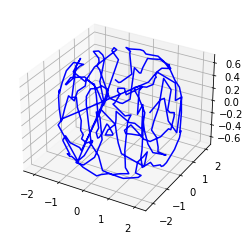

In [22]:

fig = matplotlib.pyplot.figure()
ax  = fig.add_subplot(111, projection = '3d')

X = torus_bary[:,0]
Y = torus_bary[:,1]
Z = torus_bary[:,2]
ax.plot(X, Y, Z, color = 'b')
plt.show()

# Persistent homology of sampled barycenters

/tmp/ipykernel_62162/1703124144.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  point_cloud = torch.tensor(point_cloud)


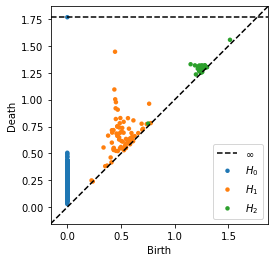

In [23]:
torus_PH_arrays,PH_diagram_barycenters_torus = get_persistence_diagram(torus_bary,2)

# Sphere

In [24]:
expr = x**2 + y**2 + z**2 - 1
poly = sp.Poly(expr, x, y, z)

In [25]:
expr

x**2 + y**2 + z**2 - 1

In [26]:
    # convert sympy polynomial to minyterpy polynomial
newt_poly = sympy_to_mp(poly, mp.NewtonPolynomial)

In [27]:
#sample points
point_data = sample_points_on_poly(1000,        # Number of points to be sampled
                                   newt_poly,  # Polynomial in Newton basis
                                   bounds=1, # Boundary of the Cubic domain to be sampled
                                   tol=1e-15)  # Tolerance in solution

In [28]:
point_data.shape

(1000, 3)

In [29]:

x_so = point_data[:,0]

y_so = point_data[:,1]

z_so = point_data[:,2]


plot_points = [x_so,y_so,z_so]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

In [30]:
sphere_bary = get_convergent_barycenters(point_data, 20, point_data[0])

In [31]:
sphere_bary.shape

torch.Size([30, 3])

# Trajectory of barycenter smpling on sphere


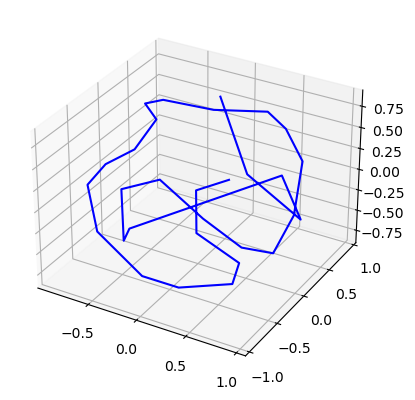

In [32]:

fig = matplotlib.pyplot.figure()
ax  = fig.add_subplot(111, projection = '3d')

X = sphere_bary[:,0]
Y = sphere_bary[:,1]
Z = sphere_bary[:,2]
ax.plot(X, Y, Z, color = 'b')
plt.show()

In [33]:
x_sb = sphere_bary[:,0]#.cpu().detach().numpy()

y_sb = sphere_bary[:,1]#.cpu().detach().numpy()

z_sb = sphere_bary[:,2]#.cpu().detach().numpy()



plot_points = [x_sb,y_sb,z_sb]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

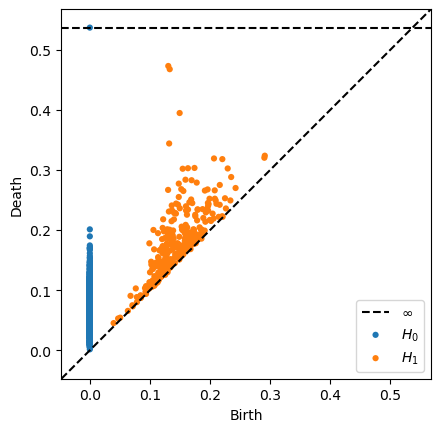

In [34]:
#original point cloud sphere persistence diagram

PH_diagram_spheres = get_persistence_diagram(point_data,1)

/tmp/ipykernel_62162/1703124144.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  point_cloud = torch.tensor(point_cloud)


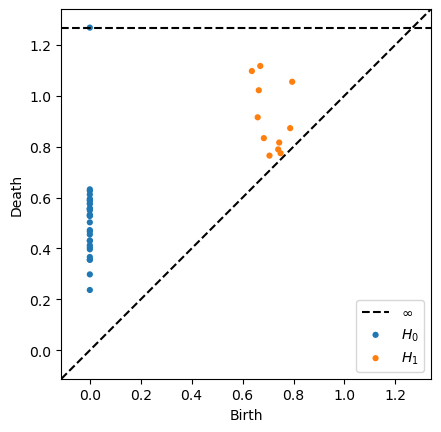

In [35]:
# barycentyers of sphere persistence diagram


PH_diagram_barycenters_sphere = get_persistence_diagram(sphere_bary, 1)